In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_20 import MapDatasetNuisance
from MapDatasetNuisanceE import MapDatasetNuisanceE
from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
penality 0 []
MapDataset
----------

  Name                            : JgEeSwhe 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Tem

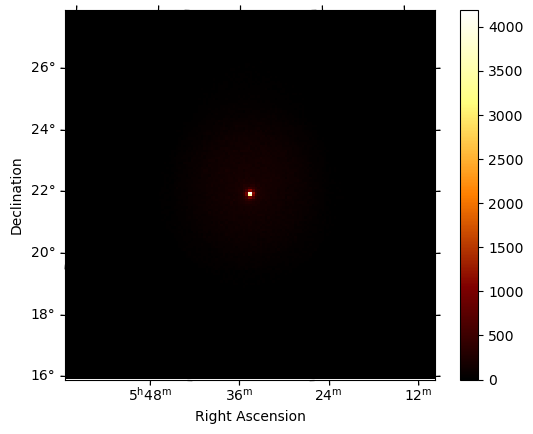

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

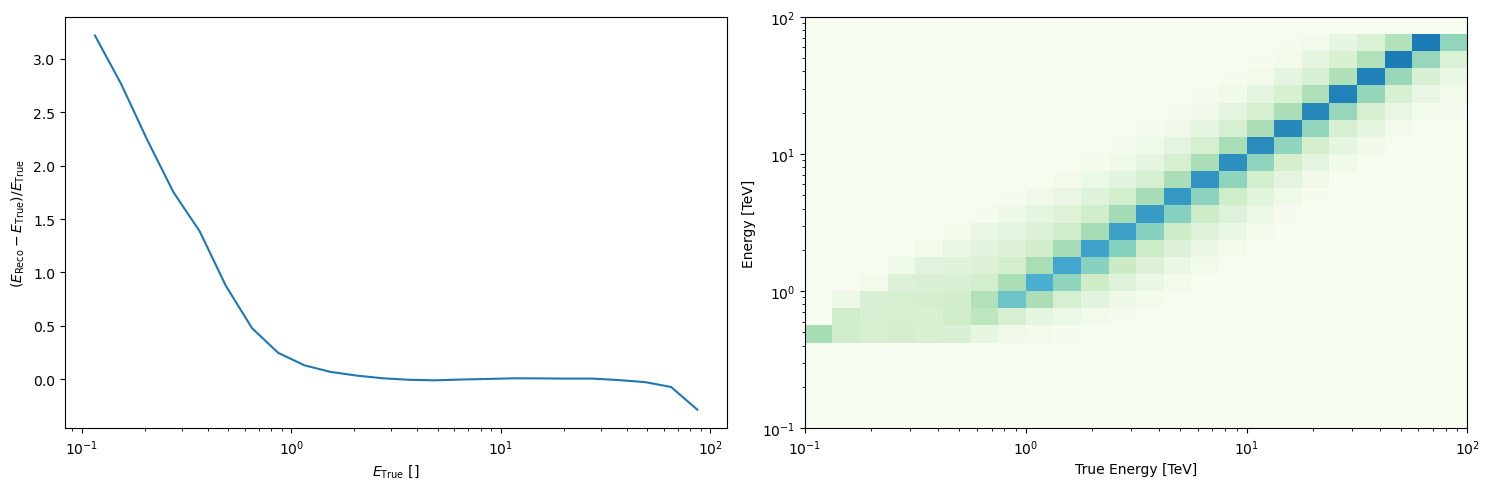

In [4]:
dataset_standard.edisp.peek()

In [5]:
dataset_standard.exposure.plot_interactive()
print(dataset_standard.exposure.unit)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

m2 s


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64



<WCSAxesSubplot: >

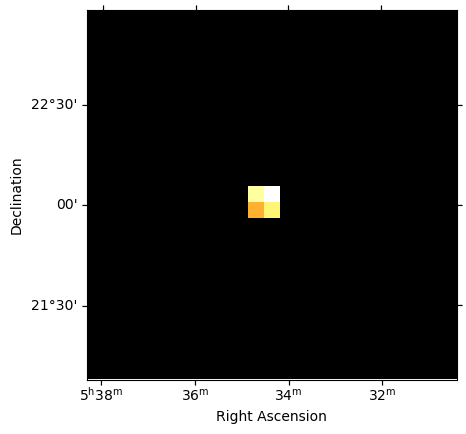

In [6]:
flux = dataset_standard.evaluators['Source'].compute_flux()
print(flux)
flux.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

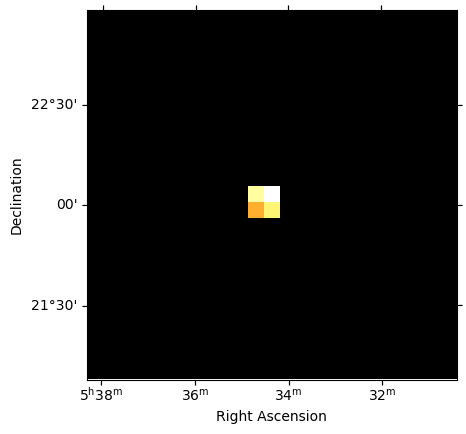

In [7]:
npred = dataset_standard.evaluators['Source'].apply_exposure(flux)
print(npred)
npred.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

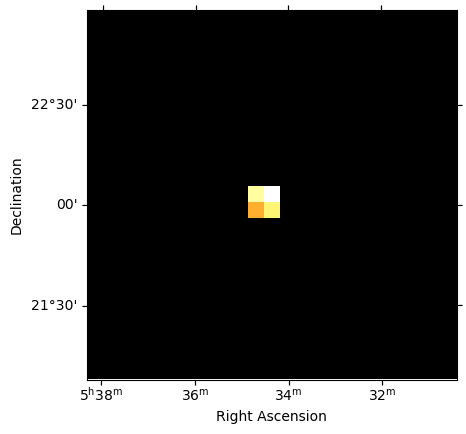

In [8]:
npred_reco = dataset_standard.evaluators['Source'].apply_edisp(npred)
print(npred_reco)
npred_reco.slice_by_idx(dict(energy = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float32



<WCSAxesSubplot: >

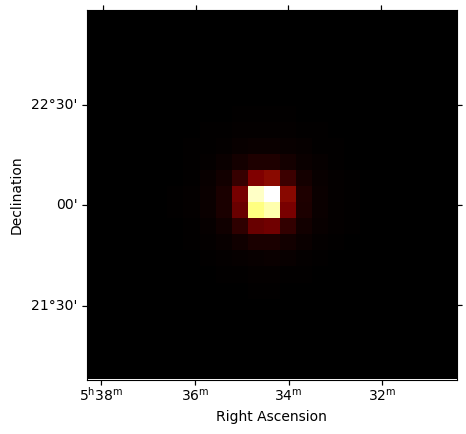

In [9]:
npred_reco_con = dataset_standard.evaluators['Source'].apply_psf(npred_reco)
print(npred_reco_con)
npred_reco_con.slice_by_idx(dict(energy = slice(10,11))).plot()

## Varying the Exposure

In [10]:
factor_neg = -0.1
factor_pos = +0.1

In [11]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos = sys_d_pos.create_dataset()



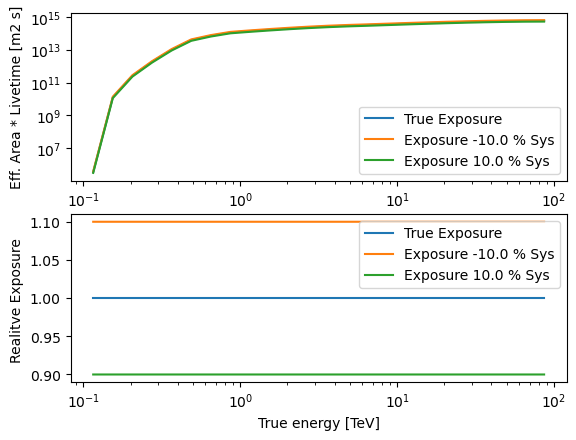

In [12]:
fig,ax = plt.subplots(2,1)

true_energy = dataset_cor.exposure.geom.axes[0].center.value
exposure_e = dataset_cor.exposure.data.sum(axis =2).sum(axis =1)

ax[0].plot(true_energy, exposure_e, label = "True Exposure")
ax[0].plot(true_energy, dataset_neg.exposure.data.sum(axis =2).sum(axis =1),
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[0].plot(true_energy, dataset_pos.exposure.data.sum(axis =2).sum(axis =1), 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_standard.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_e, label = "True Exposure")
ax[1].plot(true_energy, (dataset_neg.exposure.data.sum(axis =2).sum(axis =1))/exposure_e,
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[1].plot(true_energy, (dataset_pos.exposure.data.sum(axis =2).sum(axis =1))/ exposure_e, 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Realitve Exposure ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

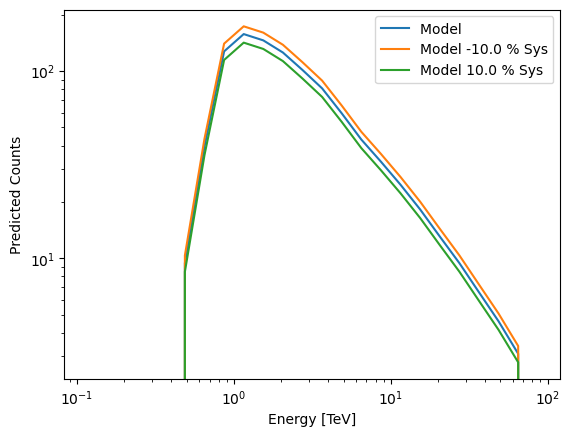

In [13]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred = dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


plt.plot(true_energy, npred, label = "Model ")
plt.plot(true_energy, npred_neg, label = "Model {:.3} % Sys".format(factor_neg *100))
plt.plot(true_energy, npred_pos, label = "Model {:.4} % Sys".format(factor_pos * 100))

         
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Predicted Counts")

fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

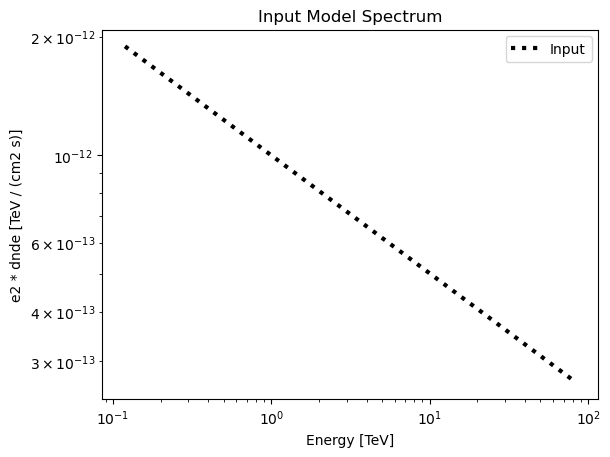

In [14]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_standard.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

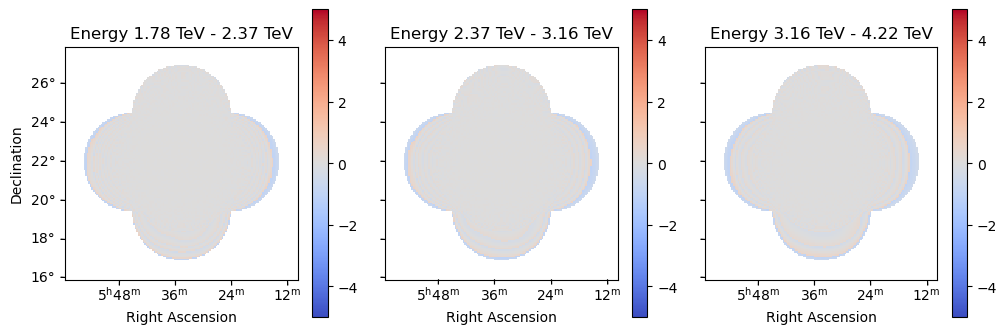

In [15]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

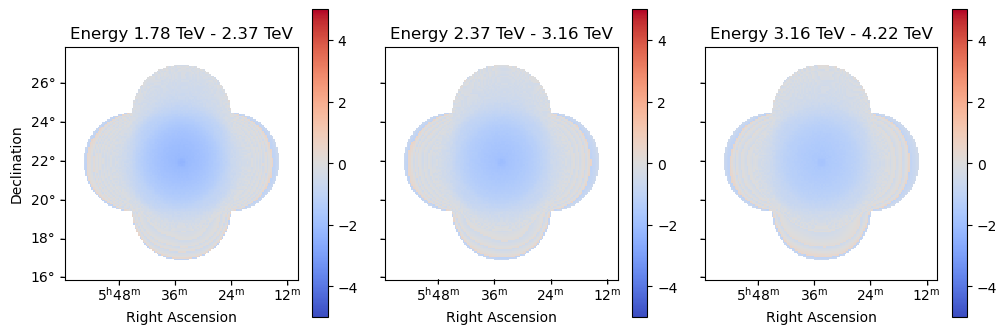

In [16]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

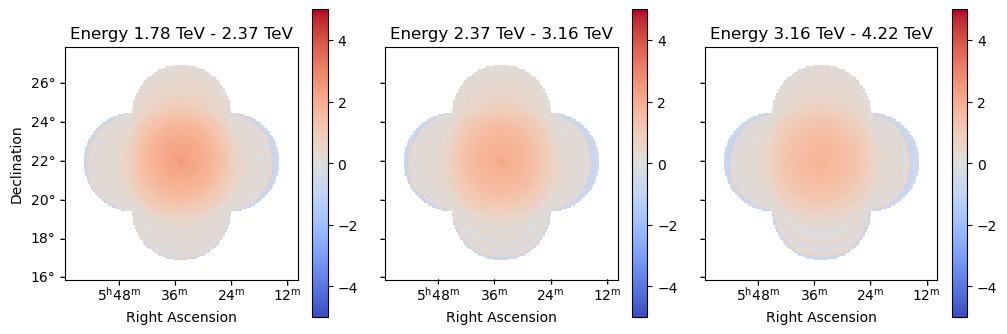

In [17]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [18]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penali

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/my_fit_20.py:218: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  trace = table_from_row_data(info.pop("trace"))


penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penali

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/my_fit_20.py:218: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  trace = table_from_row_data(info.pop("trace"))


penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penality 0 []
penali

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/my_fit_20.py:218: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  trace = table_from_row_data(info.pop("trace"))


In [19]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_standard.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_standard.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_standard.background_model.parameters['norm'].value 
error = dataset_standard.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
    
    
    
with open('data/norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0
====
9.105796264262845e-13 pm 8.347326944029948e-14
1e-12 pm 8.983236447545194e-14
1.1149869832838232e-12 pm 1.0317181993071686e-13

best fit Index
====
Input
2.3 pm 0
====
2.2997022720555913 pm 0.06173136512497852
2.3 pm 0.06171759673210689
2.3005502367895008 pm 0.06180242418427357

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9090867612494103 pm 0.0018786603594064628
1.0 pm 0.002062394132306287
1.1110956238407124 pm 0.002296587242052484


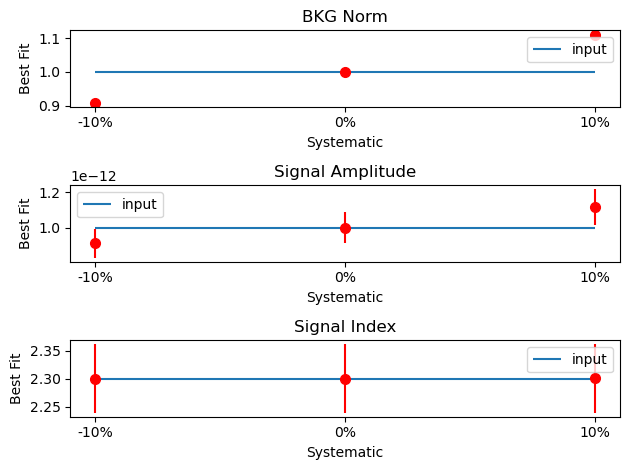

In [20]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_nocorr.pdf")   


In [21]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : XGk2qKKM
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.631   +/-    0.00 deg         
    lat_0                         :     22.018   +/-    0.00 deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : 405TUDa9-bkg
  Datasets names            : ['405TUDa9']
  Spectral model type       : PowerLawNormSpectra

index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude


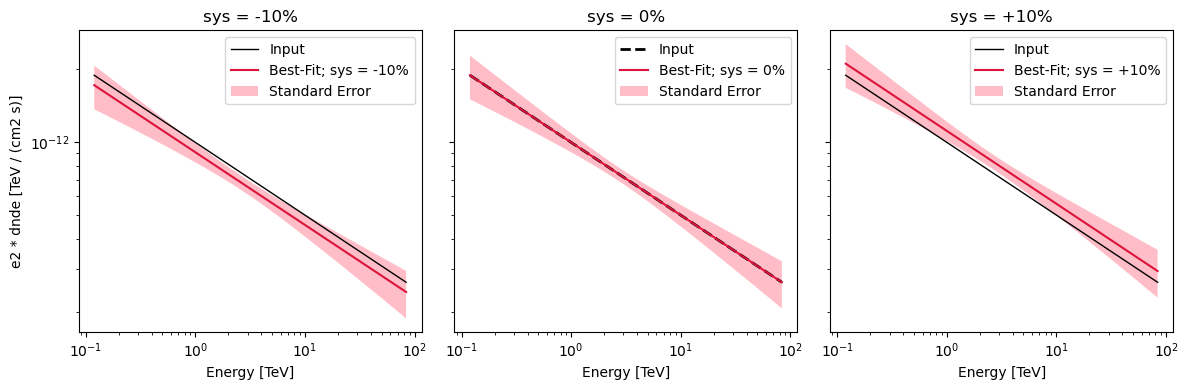

In [22]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

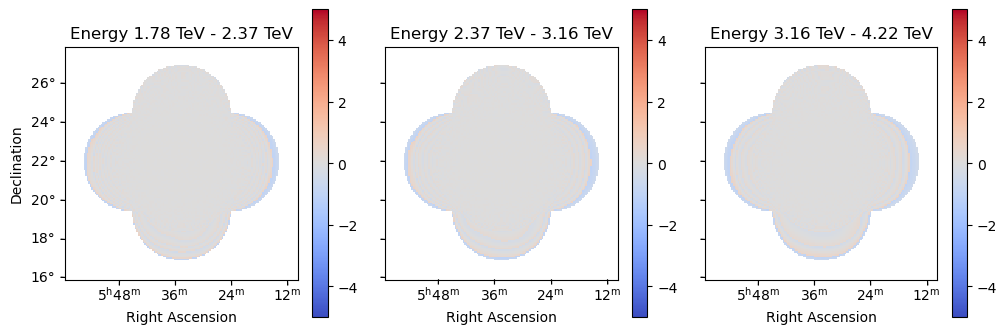

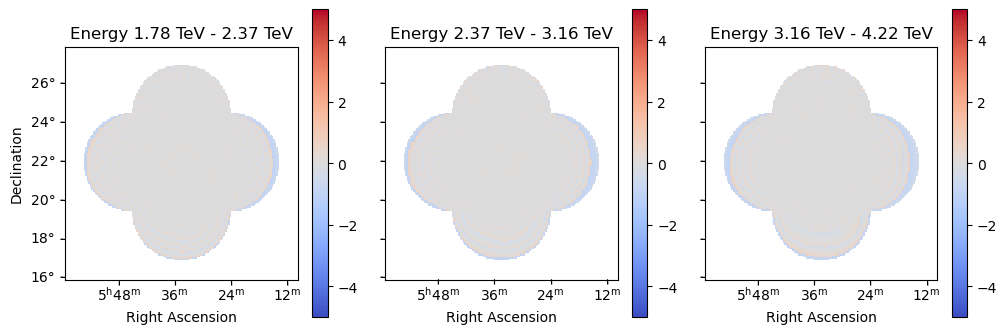

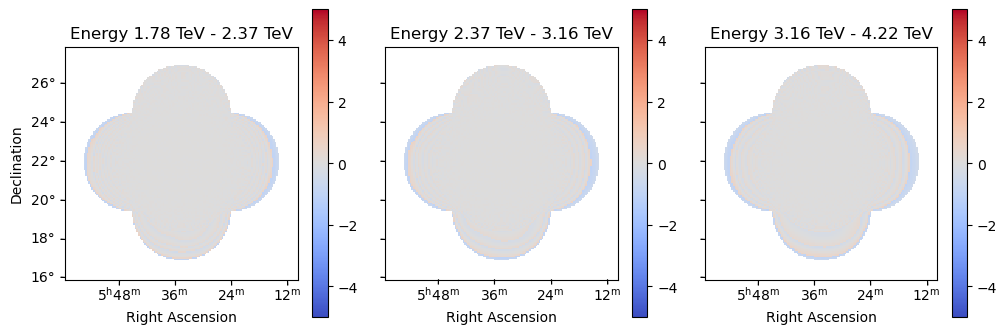

In [23]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

## Mulitple Poission Draws

In [24]:
N = 10
datasets_cor = []
datasets_neg = []
datasets_pos = []

sys_d_cor_rnd = sys_dataset(dataset_asimov, 0, True)
sys_d_neg_rnd = sys_dataset(dataset_asimov, factor_neg, True)
sys_d_pos_rnd = sys_dataset(dataset_asimov, factor_pos, True)


for n in range(N):
    datasets_cor.append(sys_d_cor_rnd.create_dataset())
    datasets_neg.append(sys_d_neg_rnd.create_dataset())
    datasets_pos.append(sys_d_pos_rnd.create_dataset())


In [25]:
%%time


fitting_poission_draws = False


if fitting_poission_draws:
    for i, d in enumerate(datasets_cor):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    for i, d in enumerate( datasets_neg):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    for i, d in enumerate (datasets_pos):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        
        
    amplitudes_all = []
    indices_all = []
    norms_all = []

    datasets_p = [datasets_neg, datasets_cor, datasets_pos]
    for d_case in datasets_p:
        print("best fit amplitude")
        amplitudes_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['amplitude'].value 
            error = m.parameters['amplitude'].error
            amplitudes_p.append((value, error))
            print(f'{value} pm {error}')
        print()
        print("best fit Index")
        indices_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['index'].value 
            error = m.parameters['index'].error
            indices_p.append((value, error))
            print(f'{value} pm {error}')
        print()

        print("Best Fit bkg Norm")
        norms_p = []
        print('====')
        for d in d_case:
            value = d.background_model.parameters['norm'].value 
            error = d.background_model.parameters['norm'].error
            print(f'{value} pm {error}')
            norms_p.append((value, error))

        amplitudes_all.append(amplitudes_p)
        indices_all.append(indices_p)
        norms_all.append(norms_p)    
        
        
        
    with open('data/norms_all.yaml', 'w') as file:
        documents = yaml.dump(norms_all, file)
    with open('data/amplitudes_all.yaml', 'w') as file:
        documents = yaml.dump(amplitudes_all, file)
    with open('data/indices_all.yaml', 'w') as file:
        documents = yaml.dump(indices_all, file)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


In [26]:
if ~fitting_poission_draws:
    with open('data/norms_all.yaml') as file:
        norms_all = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/amplitudes_all.yaml') as file:
        amplitudes_all = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/indices_all.yaml') as file:
        indices_all = yaml.load( file, Loader=yaml.FullLoader)

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


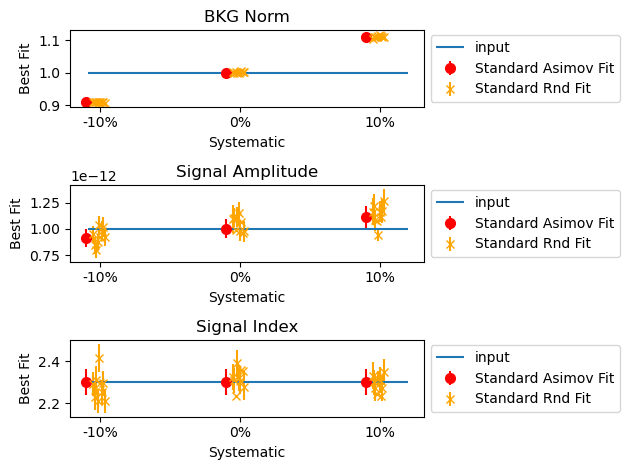

In [27]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = 'Standard Asimov Fit'
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)

for j in range(3):
    label = 'Standard Rnd Fit'
    
    for i, a in enumerate(norms_all[j][1:]):
        axs[0].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(amplitudes_all[j][1:]):
        axs[1].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(indices_all[j][1:]):
        axs[2].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)

        
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for a in axs:
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    
    #a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_nocorr.pdf")   
